# GCC's ssc-cdi : Tomography Interface for Cateretê, v1.0.0
 
- #### Run first cell to connect to server and install requirements. Run second cell to deploy interface.
- #### To visualize outputs in real time, open the log console at: View > Show Log Console
- #### Questions? E-mail gcc@lnls.br
- #### Installation and User guide [available here](https://10.10.10.141/ssc/wiki/). 
- #### About sscPimega:
    - Measurements done up to July 1st, 2022: use version sscPimega = '0.0.4'
    - Measurements made between July 2nd and October 23rd, 2022: use version sscPimega = '0.0.6'
    - Measurements made from October 24th, 2022: use version sscPimega = '0.1.1'
<!-- - #### <center>Remember to restart the kernel every time you install a new version of a package! :) </center> -->


In [1]:
install_packages = False
%matplotlib widget
import sscInstall, os
server = sscInstall.connect_server()
if install_packages:
    print("The kernel will restart after installation. Please run the cell again using install_packages = False")
    sscInstall.install_jupyter(server,beamline='caterete',sscCdi='0.3.3',sscPtycho='1.0.2',sscPimega='0.1.1',sscRaft='1.0.3',sscRadon='1.0.0',sscResolution='1.2.3')
    os._exit(00)
from sscCdi import jupyter, tomo_jupyter
header,tabs, input_variables_dict = tomo_jupyter.deploy_tabs(server)
display(header,tabs)

Username: yuri.tonin


Password:


 ············


/home/ABTLUS/yuri.tonin/.local/lib/python3.6/site-packages/sscCdi
to be done!
/home/ABTLUS/yuri.tonin/.local/lib/python3.6/site-packages/sscRaft/lib/libraft.cpython-36m-powerpc64le-linux-gnu.so


In [31]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
def auto_crop_noise_borders(complex_array):
    """ Crop noisy borders of the reconstructed object using a local entropy map of the phase

    Args:
        complex_array : reconstructed object

    Returns:
        cropped_array : object without noisy borders
    """    
    import skimage.filters
    from skimage.morphology import disk

    img = np.angle(complex_array)  # get phase to perform cropping analysis

    img_gradient = skimage.filters.scharr(img)
    img_gradient = skimage.util.img_as_ubyte(img_gradient / img_gradient.max())
    local_entropy_map = skimage.filters.rank.entropy(img_gradient, disk(5)) # disk gives size of the region used to calculate local entropy

    smallest_img_dimension = 200
    max_crop = img.shape[0] // 2 - smallest_img_dimension // 2  # smallest image after cropping will have 2*100 pixels in each direction

    crop_sizes = range(1, max_crop, 10)

    mean_list = []
    for c in (crop_sizes):
        """
        mean is a good metric since we expect it to decrease as high entropy border
        gets cropped, and increase again as the low entropy smooth background gets cropped.
        it may become an issue if the sample is displaced from the center, though
        """
        mean = (local_entropy_map[c:-c, c:-c].ravel()).mean()
        mean_list.append(mean)

    best_crop = crop_sizes[np.where(mean_list == min(mean_list))[0][0]]

    cropped_array = complex_array[best_crop:-best_crop, best_crop:-best_crop]  # crop original complex image

    if 0:  # debug / see results
        figure, subplot = plt.subplots(1, 3, figsize=(10, 10), dpi=200)
        subplot[0].imshow(img)
        subplot[1].imshow(local_entropy_map)
        subplot[2].imshow(np.angle(cropped_array))
        subplot[0].set_title('Original')
        subplot[1].set_title('Local entropy')

        subplot[2].set_title('Cropped')

        figure, subplot = plt.subplots()
        subplot.plot(crop_sizes, mean_list)
        subplot.set_xlabel('Crop size')
        subplot.set_ylabel('Mean')
        subplot.grid()

    # if cropped_array.shape[0] % 2 != 0:  # object array must have even number of pixels to avoid bug during the phase unwrapping later on
    #     cropped_array = cropped_array[0:-1, :]
    # if cropped_array.shape[1] % 2 != 0:
    #     cropped_array = cropped_array[:, 0:-1]

    return best_crop

#     # sinogram = np.ones((15,100,100))
#     path = "/ibira/lnls/labs/tepui/proposals/20210062/yuri/yuri_ssc-cdi/00000000/proc/recons/svwt_candb_mem2_01/Phase_cropped_sinogram.npy"
#     sinogram = np.load(path)

#     for frame in range(sinogram.shape[0]):
#         if frame%10==0: print(frame)
#         min_crop_value = []
#         best_crop = auto_crop_noise_borders(sinogram[frame,:,:])
#         min_crop_value.append(best_crop)
#         # print(best_crop)
#     min_crop = min(min_crop_value)

#     cropped_sinogram = sinogram[:, min_crop:-min_crop-1, min_crop:-min_crop-1]

#     if cropped_sinogram.shape[1] % 2 != 0:  # object array must have even number of pixels to avoid bug during the phase unwrapping later on
#         cropped_sinogram = cropped_sinogram[:,0:-1, :]
#     if cropped_sinogram.shape[2] % 2 != 0:
#         cropped_sinogram = cropped_sinogram[:,:, 0:-1]

def get_extrapolated_sinogram(sino, pad, L, R):
    if pad==0:
        return sino
    else:
        nrays = sino.shape[0]
        nangles = sino.shape[1]
        n = nrays + 2*pad
        s = numpy.vstack((numpy.zeros([pad,nangles]),sino,numpy.zeros([pad,nangles])) )
        t = numpy.linspace(-1,1,n)
        left = (1.0*(( t < t[pad] ) )) 
        right =  1.0 * (t > t[nrays+pad-1])
        L_ = 1
        R_ = 1
        p = numpy.array( [ s[:,j] + L_*s[pad,j]*numpy.exp(L*(t-t[pad]))*left + R_*s[nrays+pad-1,j]*right*numpy.exp(-R*(t-t[nrays+pad-1])) for j in range(nangles)] ).T
        return p
    
#     size_rays = data.shape[1]*data.shape[2]
#     n_angles = data.shape[0]

#     print(data.shape[1],data.shape[2])

#     sino = np.zeros((size_rays,n_angles))

#     for i in range(data.shape[0]):
#         if i+1%10==0: print(i)
#         sino[:,i] = data[i,:,:].flatten()

#     L    = 10
#     R    = 10
#     pad  = 150
#     sino_ext = get_extrapolated_sinogram( sino, pad, L, R)

#     print(sino.shape,sino_ext.shape,sino.shape[0]-sino_ext.shape[0])

#     print(sino_ext.shape[0]/(data.shape[1]-pad))

#     new_shape = (int(sino_ext.shape[0]/(data.shape[1]-pad)),int(sino_ext.shape[0]/(data.shape[2]-pad)),sino_ext.shape[1])
#     print("New shape", new_shape)
#     sino_reshaped = np.reshape(sino_ext, new_shape)

#     print(sino_reshaped.shape)

def func_old(x,alpha):
    func = 1 - np.exp(alpha*x)
    func = func / np.max(np.abs(func)) + 1
    return func

def func(x,alpha,cut=8):
    maximum = np.max(np.where(np.abs(x)<cut,0,1 - np.exp(alpha*x)))
    # func += np.where(np.abs(x) < cut,maximum,1 - np.exp(alpha*x))
    func = np.where(np.abs(x) < cut ,1 - np.exp(alpha*x),0)
    func = np.where(np.abs(x) < cut, 1 + func / np.max(np.abs(func)),0)
    return func

def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def pad_sinogram_frames(padding,sinogram):
    # sinogram = np.load(path)
    # print("Old shape: ",sinogram.shape)
    sinogram = np.pad(sinogram,((0,0),(padding,padding),(padding,padding)),mode='constant')#,constant_values=((1,),(1,)))
    # print("New shape: ",sinogram.shape)
    return sinogram

def crop_custom(data):
    left = 234
    right = 236
    delta_y = 700
    top1 = 90
    top2 = 233
    frame = data[0,0:delta_y,left:-right]

    data1 = np.zeros((data.shape[0],frame.shape[0],frame.shape[1]))
    for i in range(data.shape[0]):
        if i <= 100:
            data1[i] = data[i,top1:top1+delta_y,left:-right]
        else:
            data1[i] = data[i,top2:top2+delta_y,left:-right]
    return data

def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

def RemoveGrad_new( img, mask ):
    xy = numpy.argwhere( mask > 0)
    n = len(xy)
    y = xy[:,0].reshape([n,1])
    x = xy[:,1].reshape([n,1])
    F = numpy.array([ img[y[k],x[k]] for k in range(n) ]).reshape([n,1])
    mat = numpy.zeros([3,3])
    vec = numpy.zeros([3,1])
    mat[0,0] = (x*x).sum()
    mat[0,1] = (x*y).sum()
    mat[0,2] = (x).sum()
    mat[1,0] = mat[0,1]
    mat[1,1] = (y*y).sum()
    mat[1,2] = (y).sum()
    mat[2,0] = mat[0,2]
    mat[2,1] = mat[1,2]
    mat[2,2] = n
    vec[0,0] = (x*F).sum()
    vec[1,0] = (y*F).sum()
    vec[2,0] = (F).sum()
    eye = numpy.eye(mat.shape[0])
    eps = 1e-7 # valor tirado do *
    if 1: # com regularização
        abc = numpy.dot( numpy.linalg.inv(mat + eps * eye), vec).flatten() 
    else: # sem regularização
        abc = numpy.dot( numpy.linalg.inv(mat), vec).flatten()
    a = abc[0]
    b = abc[1]
    c = abc[2]
    new   = img.copy()
    row   = new.shape[0]
    col   = new.shape[1]
    XX,YY = numpy.meshgrid(numpy.arange(col),numpy.arange(row))
    new[y, x] = img[ y, x] - ( a*XX[y,x] + b*YY[y,x] + c )
    # new = img - ( a*XX + b*YY + c )
    return new, a,b,c

def plane(variables,u,v,a):
    Xmesh,Ymesh = variables
    return np.ravel(u*Xmesh+v*Ymesh+a)


10
-0.0016939701263598468 0.004428020771090967 -1.7058609972980605
-5.59773093384198e-10 -4.205415772562393e-10 0.1654143496605398
-8.739380639508683e-10 -6.603948568550955e-10 0.16541436246025398
done


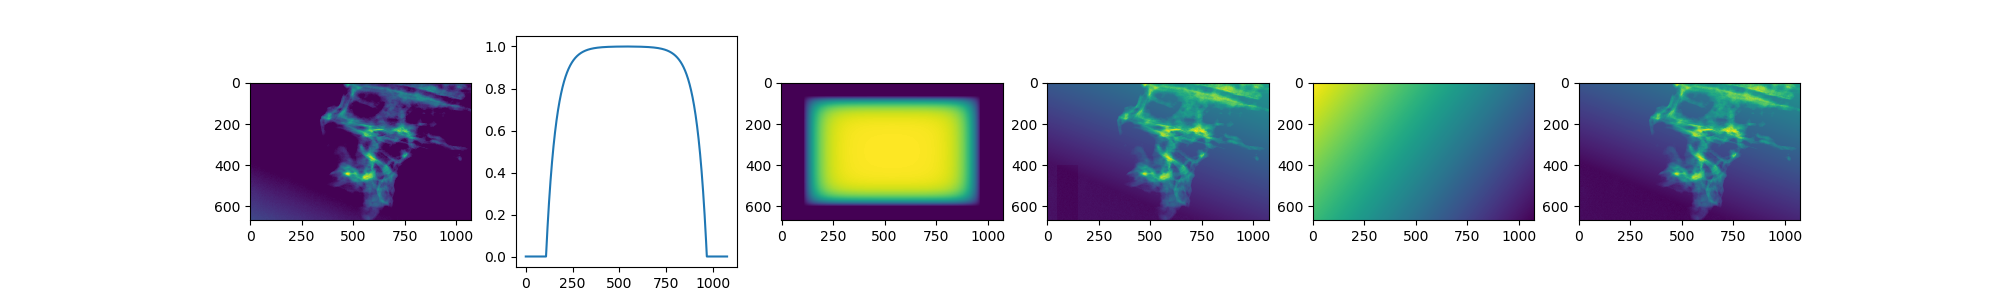

In [41]:
import numpy as np
import numpy
import matplotlib.pyplot as plt
path2 = "/ibira/lnls/labs/tepui/proposals/20210062/yuri/yuri_ssc-cdi/00000000/proc/recons/svwt_candb_mem2_01/Phase_equalized_sinogram_BKP.npy"
path = "/ibira/lnls/labs/tepui/proposals/20210062/yuri/yuri_ssc-cdi/00000000/proc/recons/svwt_candb_mem2_01/Phase_equalized_sinogram.npy"


data = np.load(path2)
# np.save(path2,data)

# crop = 150
# data = data[:,crop:-crop,crop:-crop]

# data = data[:,600:700,10:1000]

mask = np.zeros_like(data[0],dtype=bool)
mask2 = np.zeros_like(data[0],dtype=bool)

# top,bottom,left,right = 400,500,900,1100
top,bottom,left,right = 400,700,50,150
mask[top:bottom,left:right] = True
# top,bottom,left,right = 600,700,800,1100
# top,bottom,left,right = 600,700,100,1100
mask2[top:bottom,left:right] = True
# mask2 = np.ones_like(mask)
# mask2[620:680,50:900] = True

for i in range(1):
    i = 10
# for i in range(data.shape[0]):
   
    if i%10 == 0: print(i)
    
    frame = data[i].copy()

    
    """ Remove gradient from bkg """
    new   = numpy.zeros(frame.shape)
    row   = new.shape[0]
    col   = new.shape[1]
    XX,YY = numpy.meshgrid(numpy.arange(col),numpy.arange(row))
    data[i] = frame

    a = b = c = 1e9
    # while np.abs(a) > 1e-8 or np.abs(b) > 1e-8:
    for j in range(3):
        grad_removed, a,b,c = RemoveGrad_new(data[i],mask2)
        grad_removed -= np.min(grad_removed)
        plane_fit = plane((XX,YY),a,b,c).reshape(XX.shape)
        data[i] = data[i] - plane_fit
        data[i] -= np.min(data[i])

        # grad_removed2, a2,b2,c2 = RemoveGrad_new(data[i],mask2)
        # grad_removed -= np.min(grad_removed)
        # plane_fit = plane((XX,YY),a2,b2,c2).reshape(XX.shape)
        # data[i] = data[i] - plane_fit
        # data[i] -= np.min(data[i])        
        print(a,b,c)
        
    if 1: # exponential decay at border
        N = 50
        alpha = 0.2
        a = 40
        b = a
        x = np.linspace(-N,N,frame.shape[1])
        y = np.linspace(-N,N,frame.shape[0])
        func_x = np.where(x>=0,func(x,alpha,cut=a) , func(x,-alpha,cut=a))
        func_y = np.where(y>=0,func(y,alpha,cut=b) , func(y,-alpha,cut=b))
        meshY, meshX = np.meshgrid(func_x,func_y)
        border_attenuation_matrix = meshY*meshX
    elif 0: #. gaussian filter
        sigma = 2
        x = np.linspace(-5, 5,frame.shape[1])
        y = np.linspace(-5, 5,frame.shape[0])
        x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
        border_attenuation_matrix = gaus2d(x, y,sx=sigma,sy=sigma)
    

    """ Apply border filter """
    # data[i] = data[i]*border_attenuation_matrix

    # print(grad_removed[650,500],data[i][650,500])
# np.save(path,data)
    
fig, ax = plt.subplots(1,6,figsize=(20,3))
ax[0].imshow(frame)
ax[1].plot(border_attenuation_matrix[border_attenuation_matrix.shape[0]//2,:])
ax[2].imshow(border_attenuation_matrix)
ax[3].imshow(grad_removed)
ax[4].imshow(plane_fit)
ax[5].imshow(data[i])

print("done")

Using 32 parallel processes


100%|██████████| 400/400 [00:04<00:00, 89.23it/s] 


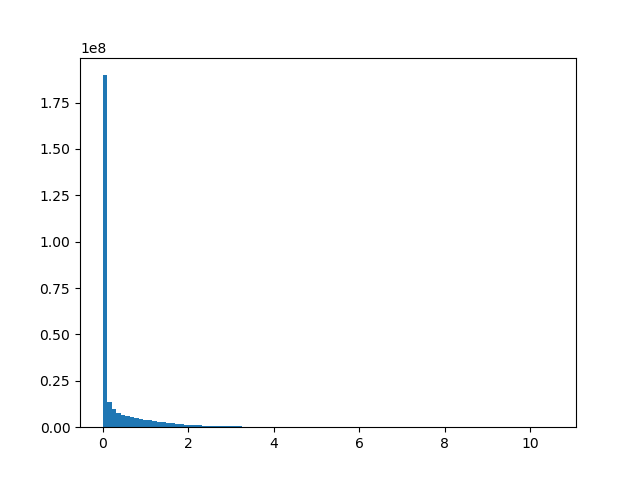

In [42]:
import numpy as np
import numpy
import matplotlib.pyplot as plt
from functools import partial
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
    
def get_best_plane_fit_inside_mask(mask2,frame ):
    new   = numpy.zeros(frame.shape)
    row   = new.shape[0]
    col   = new.shape[1]
    XX,YY = numpy.meshgrid(numpy.arange(col),numpy.arange(row))

    a = b = c = 1e9
    counter = 0
    while np.abs(a) > 1e-8 or np.abs(b) > 1e-8 or counter > 5:
        grad_removed, a,b,c = RemoveGrad_new(frame,mask2)
        plane_fit = plane((XX,YY),a,b,c).reshape(XX.shape)
        frame = frame - plane_fit
        counter += 1
    return frame
    
def border_filter_frames(loadpath,savepath,fit_region=(500,650,850,1100),cutoff=40, decay = 1, null_size=50, save=True, preview_filter=True):

    data = np.load(loadpath)

    # crop = 150
    # data = data[:,crop:-crop,crop:-crop]

    top, bottom, left, right = fit_region

    mask = np.zeros_like(data[0],dtype=bool) # mask indicating where to fit plane
    
    mask[top:bottom,left:right] = True

    get_best_plane_fit_inside_mask_partial = partial(get_best_plane_fit_inside_mask,mask2)
    
    """ Get filter """
    frame = data[0]
    if 1: # exponential decay at border
        N = null_size
        x = np.linspace(-N,N,frame.shape[1])
        y = np.linspace(-N,N,frame.shape[0])
        func_x = np.where(x>=0,func(x,decay,cut=cutoff) , func(x,-decay,cut=cutoff))
        func_y = np.where(y>=0,func(y,decay,cut=cutoff) , func(y,-decay,cut=cutoff))
        meshY, meshX = np.meshgrid(func_x,func_y)
        border_attenuation_matrix = meshY*meshX
    elif 0: #. gaussian filter
        sigma = 2
        x = np.linspace(-5, 5,frame.shape[1])
        y = np.linspace(-5, 5,frame.shape[0])
        x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
        border_attenuation_matrix = gaus2d(x, y,sx=sigma,sy=sigma)
    
    frames = [data[i] for i in range(data.shape[0])]

    """ Remove gradient from bkg """
    processes = min(os.cpu_count(),32)
    print(f'Using {processes} parallel processes')
    with ProcessPoolExecutor(max_workers=processes) as executor:
        results = list(tqdm(executor.map(get_best_plane_fit_inside_mask_partial,frames),total=data.shape[0]))
        for i, result in enumerate(results):
            data[i] = result - np.min(result)
            
    """ Apply border filter """
    data[:] = data[:]*border_attenuation_matrix

    if save: np.save(savepath,data)
                            
    return data, border_attenuation_matrix

path2 = "/ibira/lnls/labs/tepui/proposals/20210062/yuri/yuri_ssc-cdi/00000000/proc/recons/svwt_candb_mem2_01/Phase_equalized_sinogram_BKP.npy"
path = "/ibira/lnls/labs/tepui/proposals/20210062/yuri/yuri_ssc-cdi/00000000/proc/recons/svwt_candb_mem2_01/Phase_equalized_sinogram.npy"

# top,bottom,left,right = 500,600,20,150
# top,bottom,left,right = 400,500,900,1100

original_data = np.load(path2)
data, border_attenuation_matrix = border_filter_frames(path2,path,fit_region=(top,bottom,left,right),cutoff=40, decay = 0.2, null_size=50)

hist = data.ravel()
plt.figure()
plt.hist(hist,bins=100)
plt.show()

In [43]:
data = np.where(data > 10,0,data)
data = pad_sinogram_frames(150,data)

np.save(path,data)